In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 11

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/weather_data.csv")

In [ ]:
df.head()

,DATE (YYYY/MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,2020/01/01,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,2020/01/01,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,2020/01/01,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,2020/01/01,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,2020/01/01,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0


In [ ]:
df.shape

(525511, 17)

In [ ]:
#df.head()

In [ ]:
df = df[df['Total Cloud Cover [%]'] >= -1]

In [ ]:
#df.corr()

In [ ]:
df.rename(columns = {'Direct sNIP [W/m^2]':'snip', 'Total Cloud Cover [%]': 'cloud cover', 
                     'Peak Wind Speed @ 6ft [m/s]': 'wind speed', 
                     'Avg Wind Direction @ 6ft [deg from N]': 'wind dir',
                     'Tower RH [%]': 'rh', 'Global CMP22 (vent/cor) [W/m^2]': 'irr',
                     'Tower Dew Point Temp [deg C]': 'temp', 'Moisture': 'moisture',
                     }, inplace = True)

In [ ]:
df.head()

,DATE (YYYY/MM/DD),MST,irr,snip,Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],temp,rh,cloud cover,wind speed,wind dir,Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],moisture,Albedo (CMP11)
0,2020/01/01,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,2020/01/01,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,2020/01/01,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,2020/01/01,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,2020/01/01,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0


In [ ]:
req_cols = ['snip', 'wind speed', 'cloud cover', 'irr']

df = df[req_cols]

df.head()

,snip,wind speed,cloud cover,irr
0,0.000000,9.95,-1,-0.962276
1,0.000000,8.20,-1,-0.937921
2,0.000000,6.70,-1,-0.944395
3,-0.029673,7.70,-1,-0.951350
4,-0.054401,7.20,-1,-0.934976


In [ ]:
df.shape

(525511, 4)

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

420408 105103


# Preprocessing

In [ ]:
#df.head()

In [ ]:
from sklearn.preprocessing import RobustScaler

f_columns = ['snip', 'wind speed', 'cloud cover']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['irr']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['irr'] = cnt_transformer.transform(train[['irr']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['irr'] = cnt_transformer.transform(test[['irr']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
#(train['moisture'] < 0.5).sum()

In [ ]:
def create_dataset(X, y, time_steps, ccmin):
  Xs, ys = [], []
  for i in range(len(X)- 60 - time_steps):
    if (y.to_numpy()[i] == ccmin) or (y.to_numpy()[i + 60 + time_steps] == ccmin):
      continue
    Xs.append(X.iloc[i:(i + 60)].values)        
    ys.append(y.iloc[i + 60 + time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train['irr'], time_steps, train['cloud cover'].min())
X_test, y_test = create_dataset(test, test['irr'], time_steps, train['cloud cover'].min())

print(X_train.shape, y_train.shape)

(420318, 60, 4) (420318,)


In [ ]:
train['cloud cover'].min()

-0.06521739130434782

In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=8, 
      input_shape=(X_train.shape[1], X_train.shape[2]),
      return_sequences=False
    )
  )
)
model.add(keras.layers.Dropout(rate=0.1))


opt = keras.optimizers.Adam(learning_rate=0.002)
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=1024, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
370/370 [==============================] - 16s 31ms/step - loss: 0.1497 - val_loss: 0.0624
Epoch 2/50
370/370 [==============================] - 11s 29ms/step - loss: 0.1206 - val_loss: 0.0577
Epoch 3/50
370/370 [==============================] - 11s 29ms/step - loss: 0.1154 - val_loss: 0.0543
Epoch 4/50
370/370 [==============================] - 11s 29ms/step - loss: 0.1134 - val_loss: 0.0535
Epoch 5/50
370/370 [==============================] - 11s 29ms/step - loss: 0.1116 - val_loss: 0.0519
Epoch 6/50
370/370 [==============================] - 11s 29ms/step - loss: 0.1106 - val_loss: 0.0504
Epoch 7/50
370/370 [==============================] - 11s 29ms/step - loss: 0.1096 - val_loss: 0.0508
Epoch 8/50
370/370 [==============================] - 11s 29ms/step - loss: 0.1089 - val_loss: 0.0503
Epoch 9/50
370/370 [==============================] - 11s 29ms/step - loss: 0.1077 - val_loss: 0.0485
Epoch 10/50
370/370 [==============================] - 11s 29ms/step - loss: 0.107

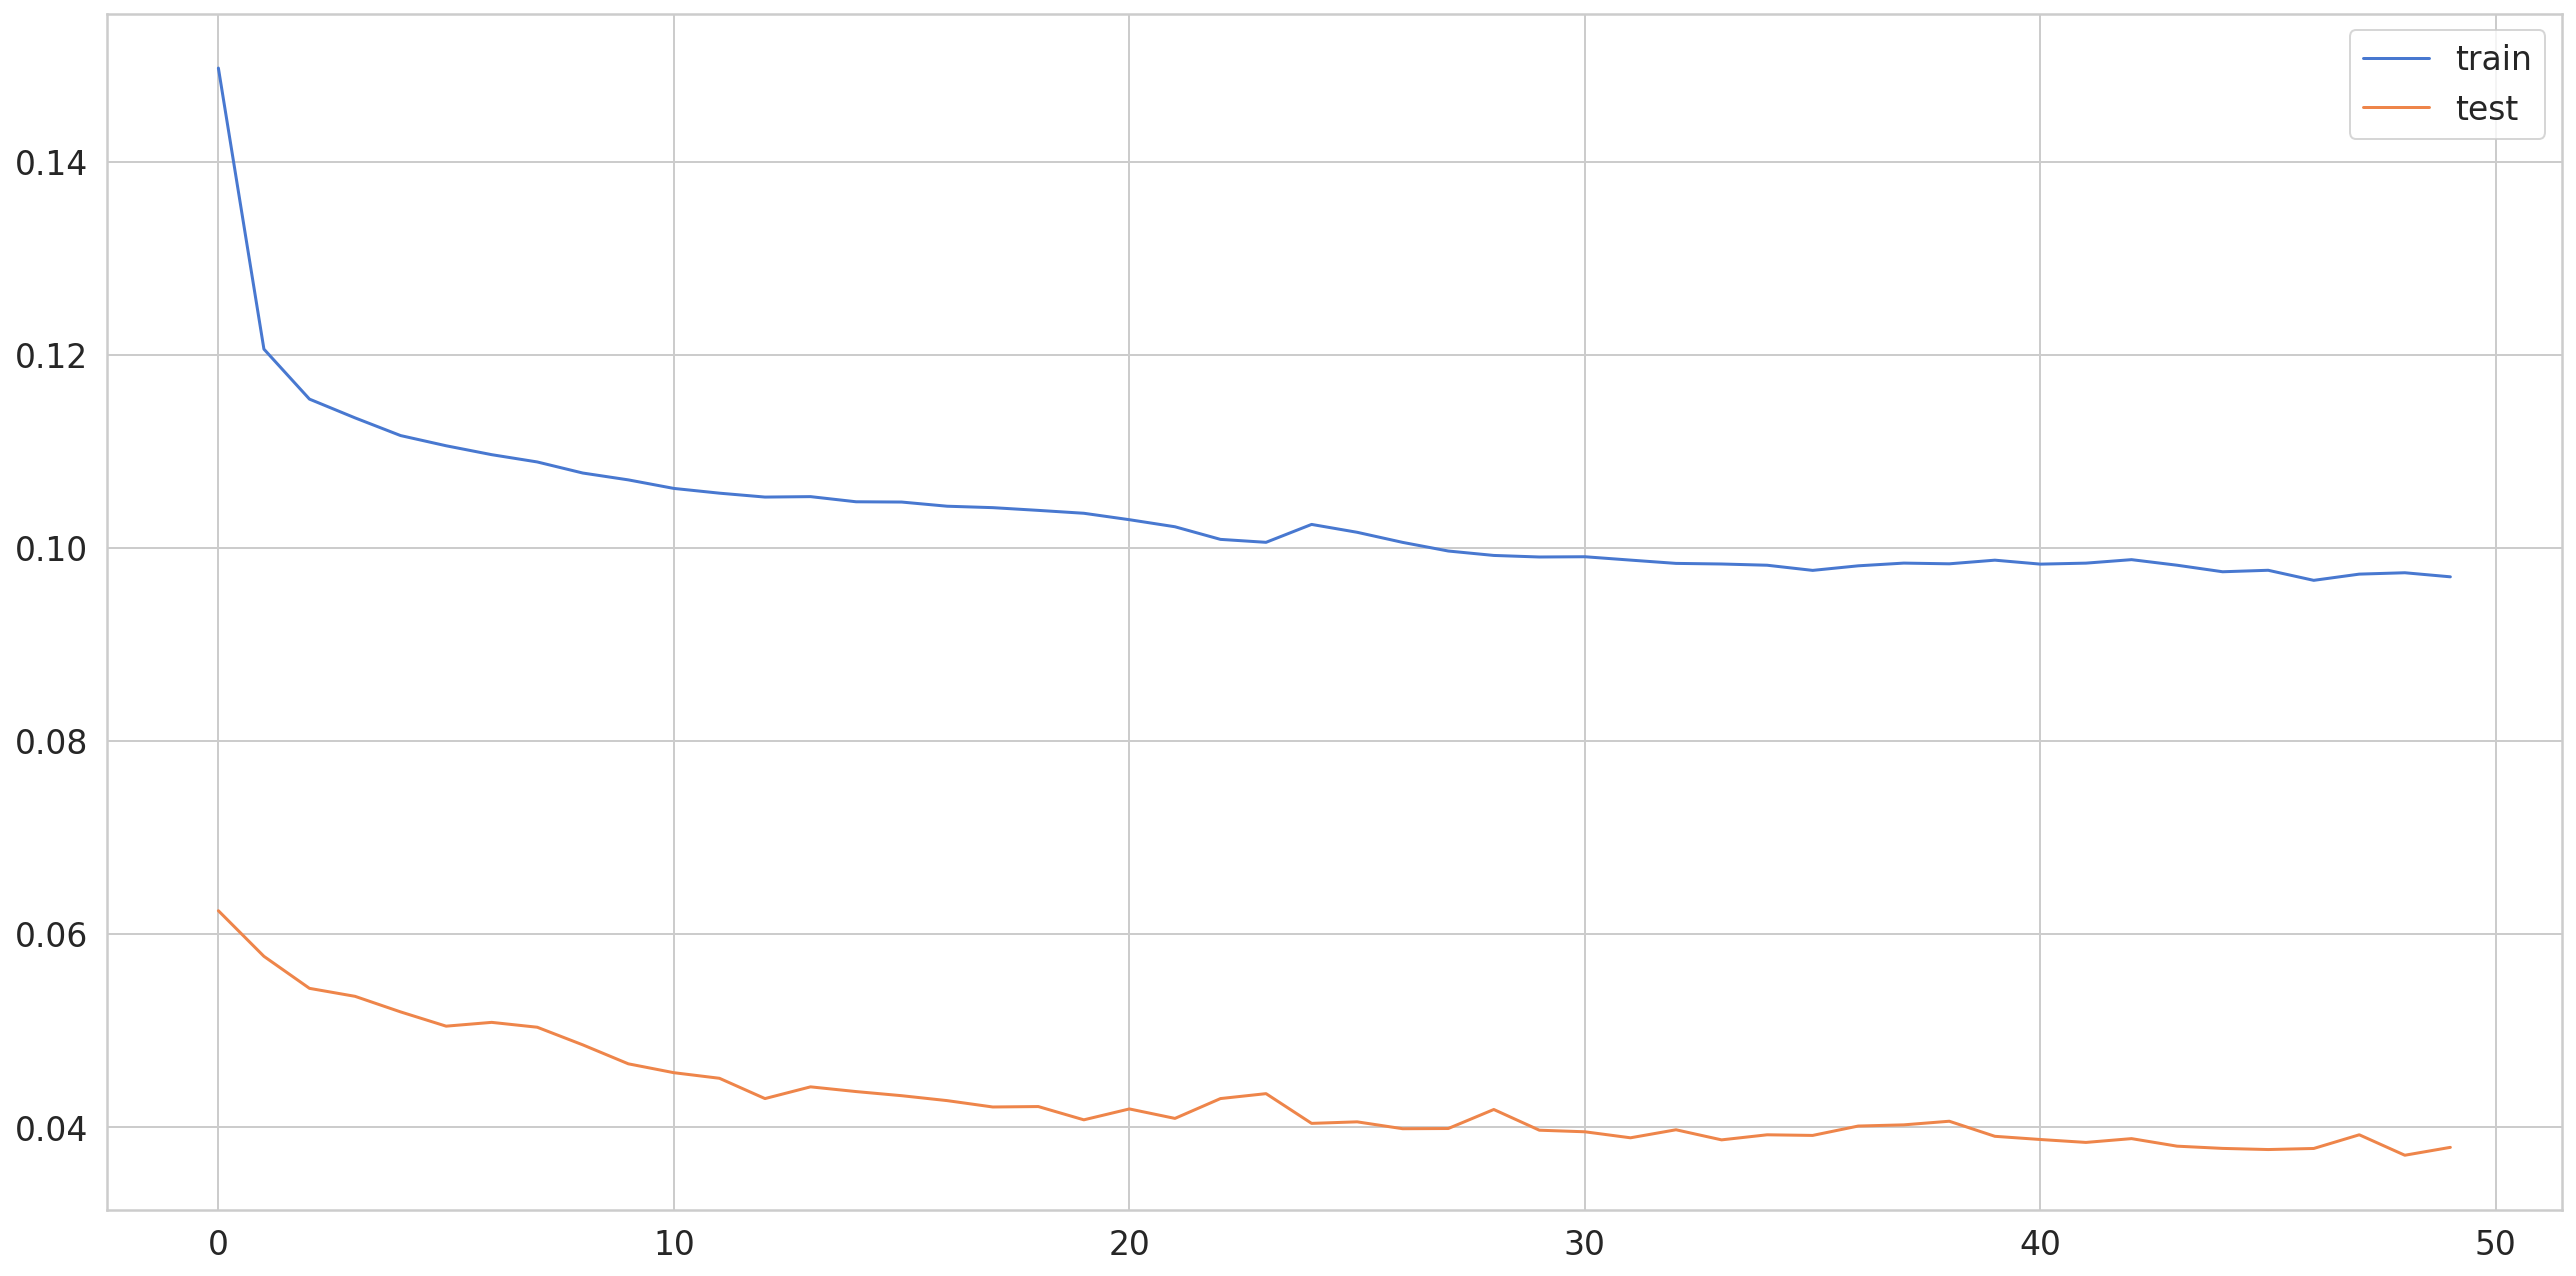

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

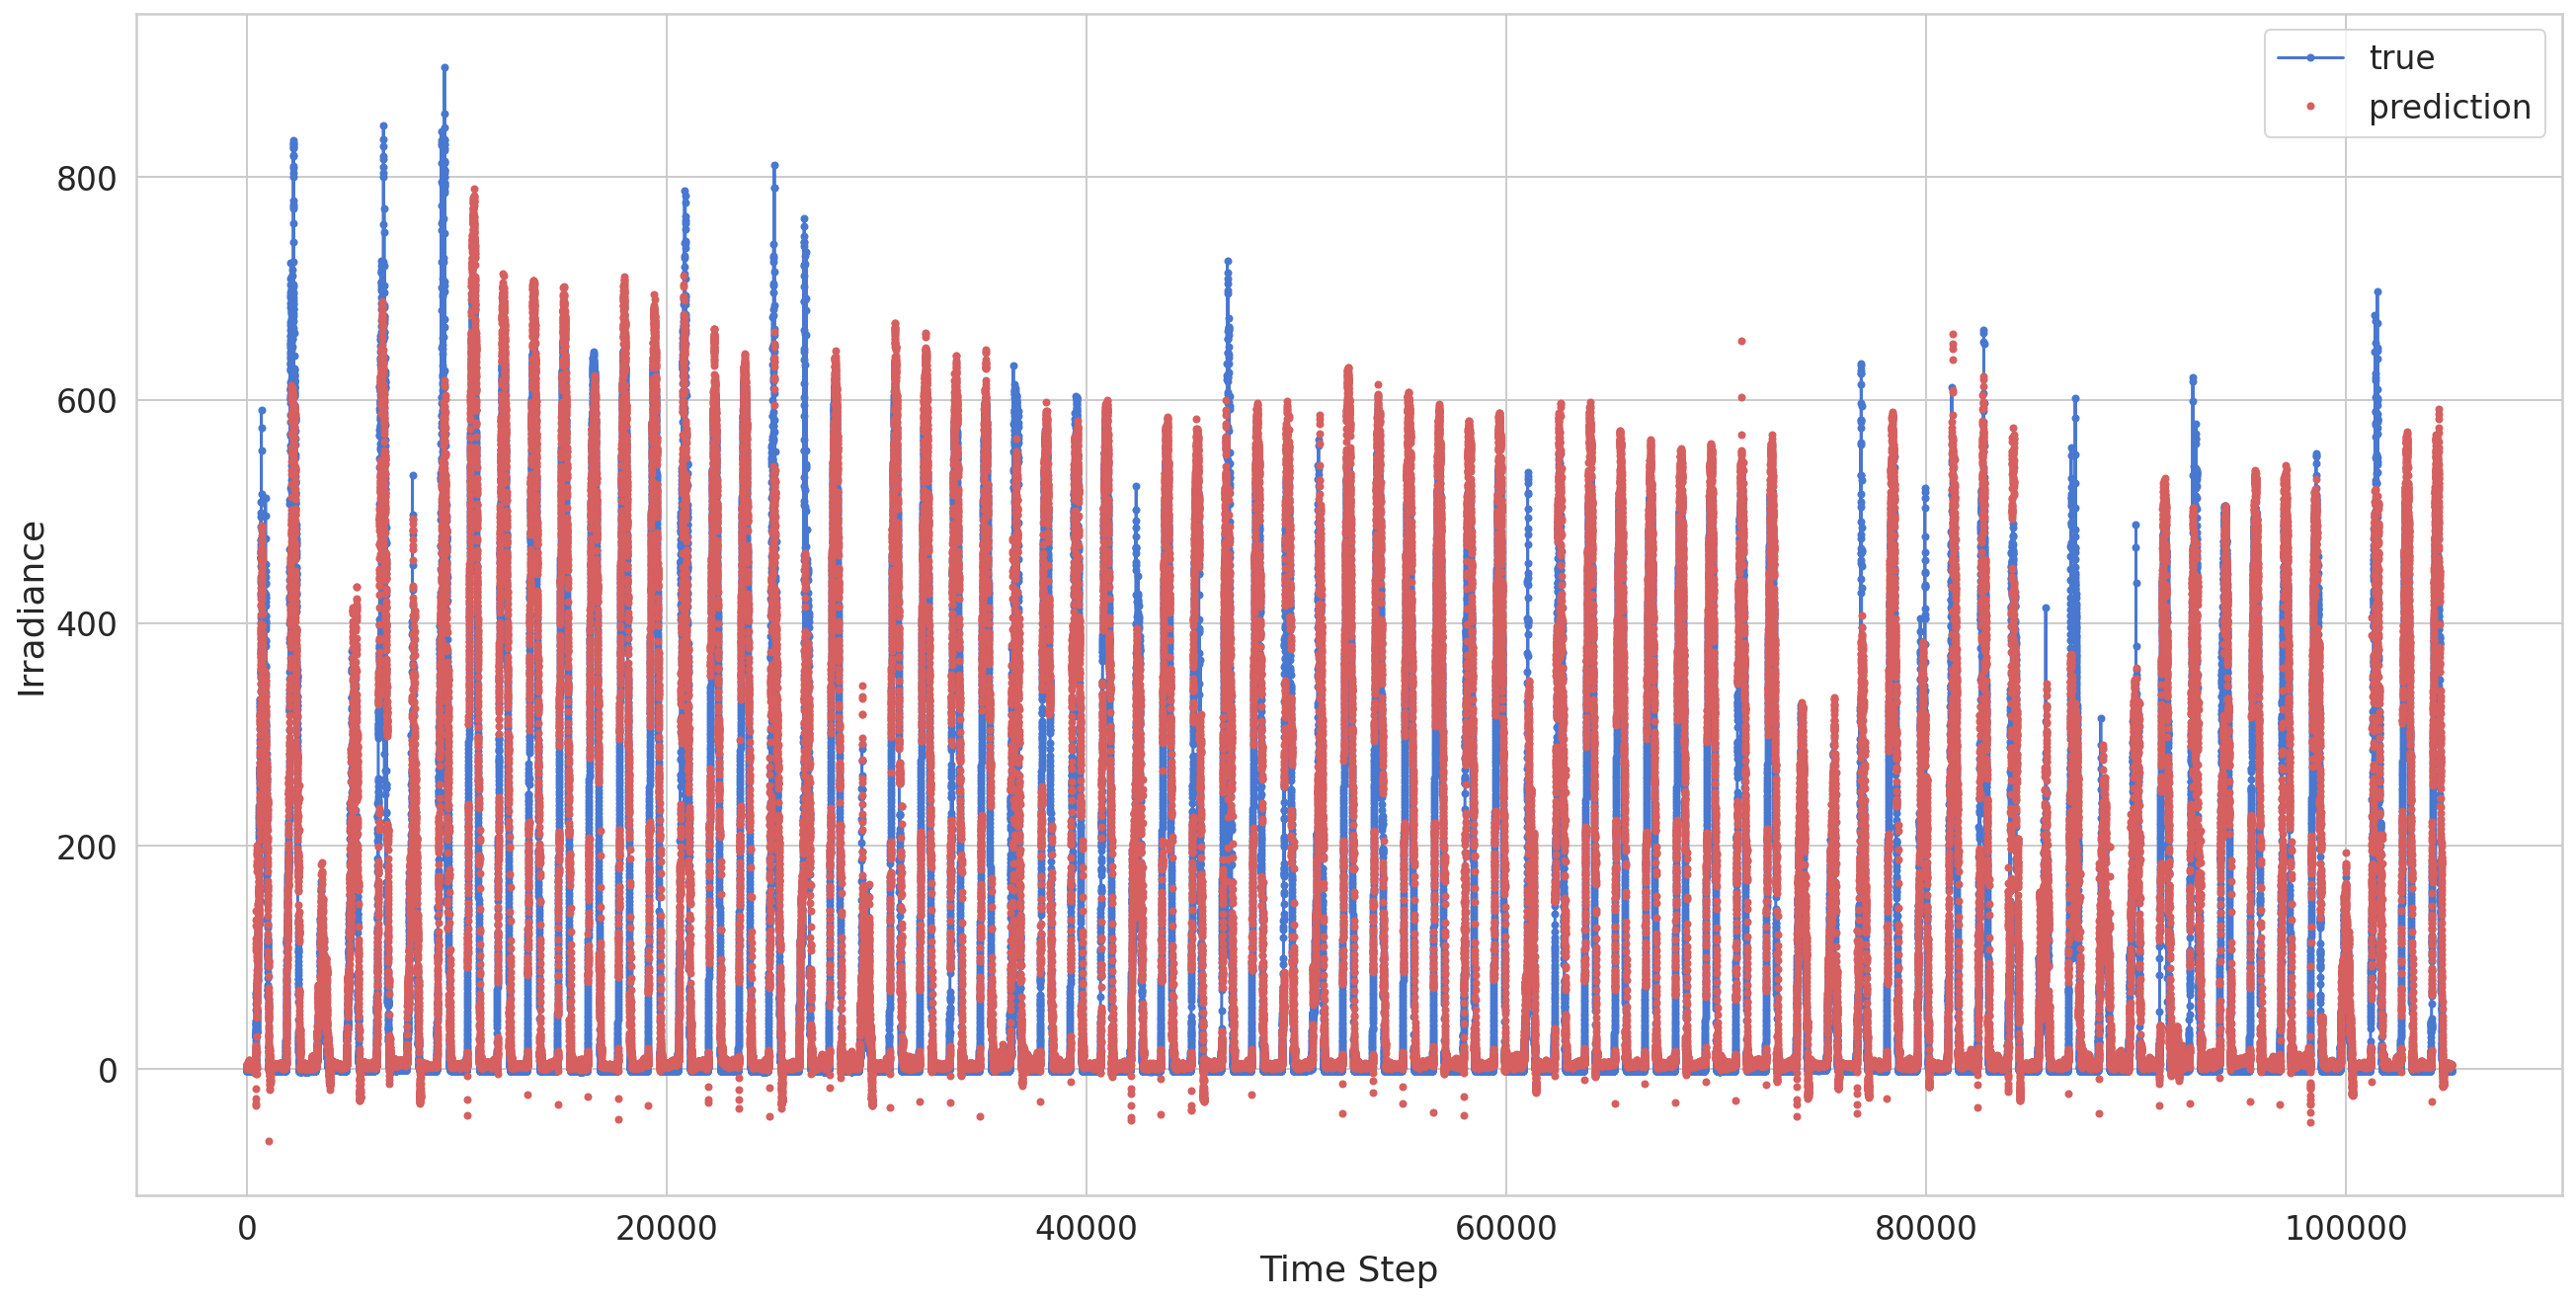

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r.', label="prediction")
plt.ylabel('Irradiance')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
def create_dataset_test(X, time_steps):
    Xs = []
    v = X.iloc[(len(X) - 60):len(X)].values
    Xs.append(v)        
    return np.array(Xs)

In [ ]:
temp = 300

vals = np.zeros(temp)

for i in range(1,temp+1):
  df_test = pd.read_csv('/content/drive/MyDrive/Shell Hackathon Level 2 Test Data/{}/weather_data.csv'.format(i))
  df_test = df_test[df_test['Total Cloud Cover [%]'] >= 0]

  df_test.rename(columns = {'Direct sNIP [W/m^2]':'snip', 'Total Cloud Cover [%]': 'cloud cover', 
                     'Peak Wind Speed @ 6ft [m/s]': 'wind speed', 
                     'Avg Wind Direction @ 6ft [deg from N]': 'wind dir',
                     'Tower RH [%]': 'rh', 'Global CMP22 (vent/cor) [W/m^2]': 'irr',
                     'Tower Dew Point Temp [deg C]': 'temp', 'Moisture': 'moisture',}, inplace = True)
  req_cols = ['snip', 'wind speed', 'cloud cover', 'irr']
  df_test = df_test[req_cols]

  df_test.loc[:, f_columns] = f_transformer.transform(df_test[f_columns].to_numpy())
  df_test['irr'] = cnt_transformer.transform(df_test[['irr']])

  X_test = create_dataset_test(df_test, time_steps)
  
  y_pred = model.predict(X_test)

  #y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
  y_pred_inv = cnt_transformer.inverse_transform(y_pred)

  vals[i-1] = y_pred_inv
  if i%30==0:
    print(int(i/3), end=' ')

10 20 30 40 50 60 70 80 90 100 

In [ ]:
vals.shape

(300,)

In [ ]:
pd.DataFrame(vals).to_csv("/content/drive/MyDrive/Shell Hackathon Submission/data{}.csv".format(time_steps))

In [ ]:
vals

array([ 512.11877441,  869.78100586,  383.91174316,  660.38250732,
        804.05065918,  761.47210693,  561.99798584,  513.01031494,
        640.12322998,  633.27264404,  605.53710938,  503.76049805,
       1006.44628906,  760.93408203,    3.87772703,  425.46743774,
         95.34410858,  109.43429565,  182.89640808,  294.06314087,
        943.59411621,  759.10992432,  702.91668701,  632.15466309,
        836.18145752,  328.01782227,  673.36749268,   48.8434639 ,
        740.56530762,  735.37683105,  665.21105957,  295.41482544,
        666.7199707 ,  896.54064941,  793.96557617,  453.53643799,
        363.4140625 ,  399.36871338,  955.85284424,  529.73254395,
        192.30180359,  502.30529785,  436.01550293,  845.91351318,
        529.90740967,  160.78578186,   61.11575317,  538.17205811,
        964.60620117,  459.37615967,  153.46728516,  514.66021729,
        230.07244873,  388.45108032,  495.36709595,  428.88208008,
        417.64105225,  813.81799316,  730.42700195,  467.85537